In [3]:
import pandas as pd
import numpy as np
from src.utils import error
from src.OPFClassifier import OptimumPathForestClassifier
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
from collections import defaultdict
from IPython.display import HTML
from IPython.display import Image
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [4]:
df_name = 'ChlorineConcentration'
df = pd.read_table(f'data/UCRArchive_2018/{df_name}/{df_name}_TRAIN.tsv', header=None)
df_test = pd.read_table(f'data/UCRArchive_2018/{df_name}/{df_name}_TEST.tsv', header=None)

X, y = df.iloc[:, 1:], df.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

# Data visualization

Before jumping to the OPF, let's take a look at the data and how it is arranged.

In [5]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
count,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,...,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000
mean,2.316916,2.915130,4.085454,3.559685,3.395815,2.838148,2.705617,2.264160,1.941362,0.797740,...,-0.046208,1.559521,0.742317,0.006121,0.451069,-0.309986,-0.532232,-0.815767,-0.558816,-0.634910
std,0.840366,1.584699,0.682733,0.485380,0.443252,0.283170,0.237441,0.182618,0.254642,0.919404,...,0.320376,0.435157,0.644322,0.346956,0.539961,0.257308,0.169126,0.149799,0.151696,0.148284
min,1.000000,-11.839069,0.574465,1.200939,1.281382,1.764394,1.730978,0.144525,0.319718,-1.028549,...,-0.604863,-0.364179,-0.566707,-0.840573,-0.544851,-0.842006,-0.950745,-1.132540,-0.965518,-1.031688
25%,2.000000,1.509055,3.512858,3.125331,3.002739,2.582323,2.503557,2.177126,1.774703,-0.026347,...,-0.340999,1.238523,0.160448,-0.245559,-0.059041,-0.503452,-0.649488,-0.918146,-0.649681,-0.729269
50%,3.000000,2.927290,4.002599,3.597416,3.425049,2.888457,2.758399,2.256554,1.921114,1.204745,...,-0.107290,1.533680,0.622688,-0.054602,0.346883,-0.352651,-0.532743,-0.826866,-0.558534,-0.636506
75%,3.000000,4.113136,4.485402,3.882100,3.695602,3.082023,2.895088,2.346816,2.106971,1.569528,...,0.210556,1.947283,1.289957,0.264004,0.879902,-0.098293,-0.414493,-0.702888,-0.454666,-0.526010
max,3.000000,7.442324,7.229240,5.514363,5.125725,3.686901,3.870352,2.927940,3.903386,2.102123,...,0.613043,2.255474,1.920397,0.861082,1.461966,0.277556,-0.052985,-0.052981,-0.052981,-0.052981


The first column represents the *label* of the given time serie. The following columns represent each point.

## Pre-processing

We can check if there is any missing value:

In [6]:
df.isnull().any().sum() + df_test.isnull().any().sum()

0

### Analysing classes

[]

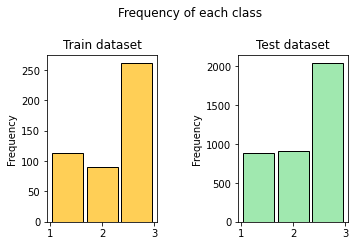

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(pad=5.0)
fig.suptitle('Frequency of each class')

df[0].plot(kind='hist', color='#FFCF56', bins=3, grid=False, rwidth=0.9, edgecolor='black', ax=ax1)
df_test[0].plot(kind='hist', color='#A0E8AF', bins=3, grid=False, rwidth=0.9, edgecolor='black', ax=ax2)

ax1.set_title('Train dataset')
ax2.set_title('Test dataset')

plt.plot()

We can try to obtain an stratified sampling of this training data, with the same frequency of each class.

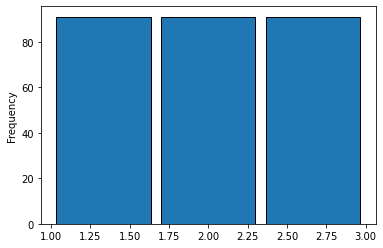

In [8]:
df_sample = df.groupby(0, group_keys=False).apply(lambda x: x.sample(91))
df_sample[0].plot(kind='hist', bins=3, grid=False, rwidth=0.9, edgecolor='black')

Stepping out of pre-processing for now, let's see how it would perform in the OPF (without any extra processing).

In [9]:
X_sample, y_sample = df_sample.iloc[:, 1:], df_sample.iloc[:, 0]
opf = OptimumPathForestClassifier('euclidean-distance')
opf.fit(X_sample, y_sample)
preds = opf.classify(X_test)
print("Stratified sample error: %.3f" % error(preds, y_test))

opf = OptimumPathForestClassifier('euclidean-distance')
opf.fit(X, y)
preds = opf.classify(X_test)
print("Raw data error: %.3f" % error(preds, y_test))

Stratified sample error: 0.482
Raw data error: 0.355


We can see that in this case, stratified samples gave us more error.

## Dimension reduction

In [10]:
opf = OptimumPathForestClassifier('euclidean-distance')
opf.fit(X, y)
preds = opf.classify(X_test)

### MDS

In [11]:
embedding = MDS(n_components=2)
X_t = embedding.fit_transform(X)
X.shape, X_t.shape

((467, 166), (467, 2))

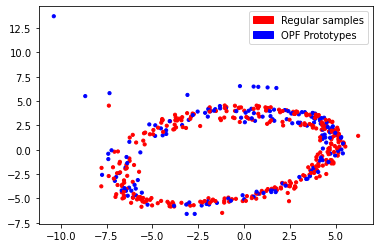

In [12]:
colors = np.array(["blue"] * X_t.shape[0])
colors[opf.prototypes] = "red"
plt.scatter(X_t[:,0], X_t[:,1], color=colors, s=10)
plt.legend(handles=[
    mpatches.Patch(color='red', label='Regular samples'),
    mpatches.Patch(color='blue', label='OPF Prototypes')
])
plt.show()

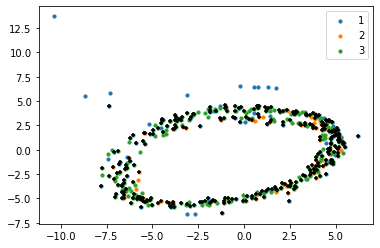

In [13]:
plt.scatter(X_t[y==1,0], X_t[y==1,1], s=10)
plt.scatter(X_t[y==2,0], X_t[y==2,1], s=10)
plt.scatter(X_t[y==3,0], X_t[y==3,1], s=10)
plt.scatter(X_t[opf.prototypes,0], X_t[opf.prototypes,1], s=13, c='black', marker='+')
plt.legend(["1", "2", "3"])
plt.show()

In [14]:
prototypes = opf.original_prototypes
print("%d prototypes were chosen (%.2f%%)" % (len(prototypes), len(prototypes)/X.shape[0]*100))

306 prototypes were chosen (65.52%)


In [15]:
# fig = plt.figure(figsize=(8,6))
# ax = plt.axes()

# def frame(w):
#     ax.clear()
#     ax.scatter(X_t[y==1,0], X_t[y==1,1], s=10)
#     ax.scatter(X_t[y==2,0], X_t[y==2,1], s=10)
#     ax.scatter(X_t[y==3,0], X_t[y==3,1], s=10)
#     ax.legend(["1", "2", "3"])
#     plot = ax.scatter(X_t[prototypes[:w],0],X_t[prototypes[:w],1], s=13, c='black', marker='+')
#     return plot

# anim = animation.FuncAnimation(fig, frame, frames=len(prototypes), interval=70)
# plt.close()
# anim.save('prototypes.gif', writer="pillow")
# HTML(anim.to_html5_video())
Image(open('prototypes.gif','rb').read())

#### Standardization

First of all, let's do a standardization of the DF.

In [16]:
X_norm = (X - X.mean()) / X.std()

In [17]:
embedding = MDS(n_components=2)
X_t = embedding.fit_transform(X_norm)
X_norm.shape, X_t.shape

((467, 166), (467, 2))

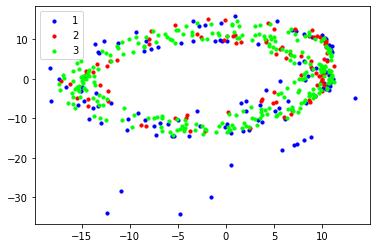

In [18]:
plt.scatter(X_t[y==1,0], X_t[y==1,1], s=10, color='blue')
plt.scatter(X_t[y==2,0], X_t[y==2,1], s=10, color='red')
plt.scatter(X_t[y==3,0], X_t[y==3,1], s=10, color='lime')
plt.legend(["1", "2", "3"])
plt.show()

### PCA

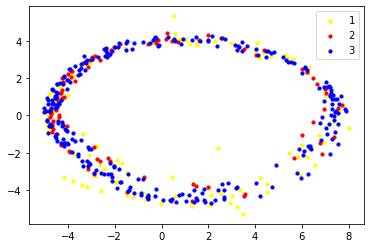

In [19]:
pca = PCA(n_components=2)
X_t = pca.fit_transform(X)
plt.scatter(X_t[y==1,0], X_t[y==1,1], s=10, color="yellow")
plt.scatter(X_t[y==2,0], X_t[y==2,1], s=10, color="red")
plt.scatter(X_t[y==3,0], X_t[y==3,1], s=10, color="blue")
plt.legend(["1", "2", "3"])
plt.show()

### LDA

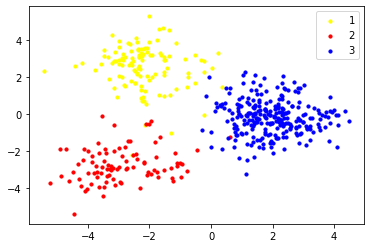

In [20]:
lda_clf = LDA(n_components=2)
X_t = lda_clf.fit_transform(X, y)
plt.scatter(X_t[y==1,0], X_t[y==1,1], s=10, color="yellow")
plt.scatter(X_t[y==2,0], X_t[y==2,1], s=10, color="red")
plt.scatter(X_t[y==3,0], X_t[y==3,1], s=10, color="blue")
plt.legend(["1", "2", "3"])
plt.show()

In [21]:
preds = lda_clf.predict(X_test)
error(preds, y_test)

0.12109375

We can see that LDA is clearly overfitted.

## OPF results

In [22]:
opf = OptimumPathForestClassifier('euclidean-distance')
opf.fit(X, y)
preds = opf.classify(X_test)

### Heatmap

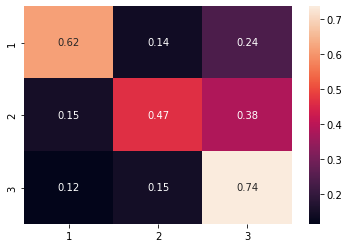

In [23]:
f = np.zeros((3, 3))
for i in range(len(preds)):
    f[y_test[i]-1][preds[i]-1] += 1
for i in range(3):
    f[i] /= f[i].sum()

# plot the heatmap
sns.heatmap(f, annot=True, xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])

### Utilizing less prototypes

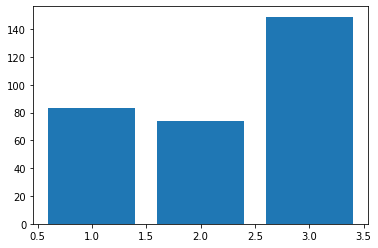

In [24]:
label_to_prot = defaultdict(list)
for prot in opf.original_prototypes:
    label_to_prot[y[prot]].append(prot)
freq_labels = {label: len(prots) for label, prots in label_to_prot.items()}
plt.bar(list(freq_labels.keys()), freq_labels.values())
plt.show()

#### First X%

In [25]:
for perc in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    prototypes = []
    for label, prots in label_to_prot.items():
        prototypes += prots[:int(perc*len(prots))]
    opf = OptimumPathForestClassifier('euclidean-distance')
    opf.fit(X, y, prototypes)
    preds = opf.classify(X_test)
    print(perc, error(preds, y_test))

0.2 0.5640625
0.3 0.5283854166666667
0.4 0.48125
0.5 0.4739583333333333
0.6 0.4395833333333333
0.7 0.42994791666666665
0.8 0.41328125
0.9 0.39791666666666664
1.0 0.35546875


#### Same amount

In [26]:
min_qtt = min([len(prots) for l, prots in label_to_prot.items()])
for qtt in [int(0.5 * min_qtt), int(0.75 * min_qtt), min_qtt]:
    prototypes = []
    for label, prots in label_to_prot.items():
        prototypes += prots[:qtt]
    opf = OptimumPathForestClassifier('euclidean-distance')
    opf.fit(X, y, prototypes)
    preds = opf.classify(X_test)
    print(qtt, error(preds, y_test))

37 0.56875
55 0.5205729166666667
74 0.48723958333333334


#### Random sample

In [27]:
for perc in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    prototypes = []
    for label, prots in label_to_prot.items():
        prototypes += list(np.random.choice(prots, int(perc*len(prots)), replace=False))
    opf = OptimumPathForestClassifier('euclidean-distance')
    opf.fit(X, y, prototypes)
    preds = opf.classify(X_test)
    print(perc, error(preds, y_test))

0.2 0.5755208333333334
0.3 0.575
0.4 0.5270833333333333
0.5 0.4984375
0.6 0.48489583333333336
0.7 0.43697916666666664
0.8 0.42291666666666666
0.9 0.38046875
1.0 0.35546875


In [28]:
min_qtt = min([len(prots) for l, prots in label_to_prot.items()])
for qtt in [int(0.5 * min_qtt), int(0.75 * min_qtt), min_qtt]:
    prototypes = []
    for label, prots in label_to_prot.items():
        prototypes += list(np.random.choice(prots, qtt, replace=False))
    opf = OptimumPathForestClassifier('euclidean-distance')
    opf.fit(X, y, prototypes)
    preds = opf.classify(X_test)
    print(qtt, error(preds, y_test))

37 0.55859375
55 0.5578125
74 0.525


#### Random prototypes

In [29]:
for qtt in [50, 100, 150, 200, 300, 400]:
    prototypes = list(np.random.choice(range(0, len(y)), qtt, replace=False))
    opf = OptimumPathForestClassifier('euclidean-distance')
    opf.fit(X, y, prototypes)
    preds = opf.classify(X_test)
    print(qtt, error(preds, y_test))

50 0.5635416666666667
100 0.5377604166666666
150 0.4734375
200 0.45390625
300 0.41067708333333336
400 0.3765625


Hence, with those simple-logic implementations, we cannot affirm that less prototypes give us better accuracy.

### Vertex used to classify

In [30]:
X = np.array(X)
y = np.array(y)
X_test = np.array(X_test)
y = np.array(y)

opf = OptimumPathForestClassifier('euclidean-distance')
opf.fit(X, y)
preds = opf.classify(X_test)

# we'll try to analyse the results of 1-NN ED and compare it with OPF
def euclidean_distance_classification(X, y, x_test):
    x_chosen = 0
    best_dist = np.linalg.norm(X[0] - x_test)
    for idx, x in enumerate(X):
        cur_dist = np.linalg.norm(X[idx] - x_test)
        if best_dist > cur_dist:
            best_dist = cur_dist
            x_chosen = idx
    return y[x_chosen], x_chosen

def opf_classification(opf, x_test):
    best_index, best_cost = opf.ordered_nodes[0]
    best_cost = max(best_cost, opf.F(opf.X[best_index], x_test))
    best_label = opf.label[best_index]
    
    for i in range(1, len(opf.X)):
        cur_index, cur_cost = opf.ordered_nodes[i]
        if cur_cost > best_cost:
            break
        cur_cost = max(cur_cost, opf.F(opf.X[cur_index], x_test))
        cur_label = opf.label[cur_index]
        if cur_cost < best_cost:
            best_index, best_cost, best_label = cur_index, cur_cost, cur_label
    return best_label, best_index

In [31]:
ed_preds = []
ed_idxs = []
opf_preds = []
opf_idxs = []
equal = 0
equal_but_diff = 0

for idx, x_test in enumerate(X_test):
    ed_label, ed_idx = euclidean_distance_classification(X, y, x_test)
    opf_label, opf_idx = opf_classification(opf, x_test)
    equal_but_diff += 1 if ed_idx == opf_idx and ed_label != opf_label else 0
    equal += 1 if ed_idx == opf_idx else 0
    ed_preds.append(ed_label)
    opf_preds.append(opf_label)
    ed_idxs.append(ed_idx)
    opf_idxs.append(opf_idx)

In [32]:
f_ed = np.zeros((3, 3))
for i in range(len(preds)):
    f_ed[y_test[i]-1][ed_preds[i]-1] += 1
for i in range(3):
    f_ed[i] /= f_ed[i].sum()

In [33]:
f_opf = np.zeros((3, 3))
for i in range(len(preds)):
    f_opf[y_test[i]-1][opf_preds[i]-1] += 1
for i in range(3):
    f_opf[i] /= f_opf[i].sum()

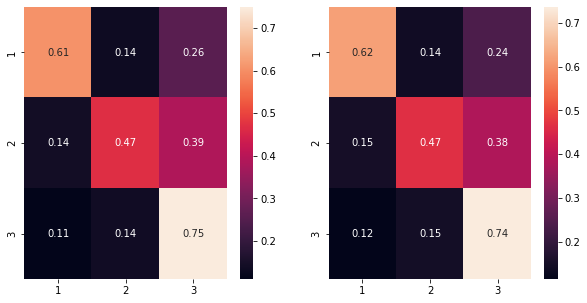

In [34]:
# plot the heatmap
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.heatmap(f_ed, ax=axes[0], annot=True, xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
sns.heatmap(f_opf, ax=axes[1], annot=True, xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])

In [35]:
error(ed_preds, y_test), error(opf_preds, y_test)

(0.35, 0.35546875)